# Filters and Background Reduction

Filters are mathematical operations that produce a new image out of one or more images. Pixel values between input and output images may differ. You can find more detailed information about how filters work in Python [here](https://biapol.github.io/DIGS-BB_LM_Course_Bio-Image_Analysis_2022/04_Image_Processing/5_Image_Filters.html).

Background reduction methods are also mathematical operations (they are also called filters in some packages). Often, they are actually [morphological operations](https://en.wikipedia.org/wiki/Mathematical_morphology) applied to images as a way to estimate the image background. More information about morphological operations in Python can be found [here](https://biapol.github.io/DIGS-BB_LM_Course_Bio-Image_Analysis_2022/04_Image_Processing/6_Morphological_operations.html).

In this notebook, we show how some filters can be used as a pre-processing step to reduce noise and how to apply some background reduction methods.

In [1]:
import numpy as np
from skimage.io import imread
from pyclesperanto_prototype import imshow
import matplotlib.pyplot as plt
from skimage.filters import median, gaussian
from skimage.morphology import disk
from skimage.restoration import rolling_ball
from skimage.morphology import disk, white_tophat
from skimage.filters import difference_of_gaussians

As example image, we will work with a zebrafish eye data set (Courtesy of Mauricio Rocha Martins, Norden lab, MPI CBG). As you can see, there is some intensity spread around the nuclei we want to segment later on. The source of this background signal is out-of-focus light.

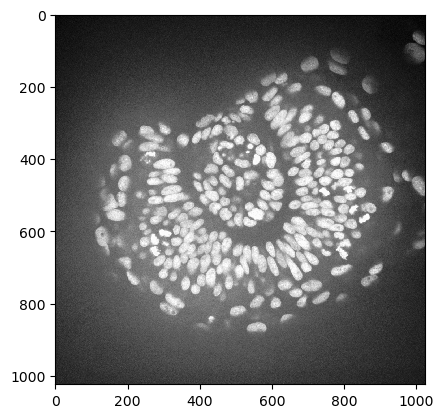

In [2]:
# load zfish image and extract a channel
zfish_image = imread('../../data/zfish_eye.tif')[:,:,0]

imshow(zfish_image)

## Filters

The simplest way to reduce noise is to slightly blur the image, for example using a gaussian or median filter.

Below, we display both filters for comparison over a cropped region.

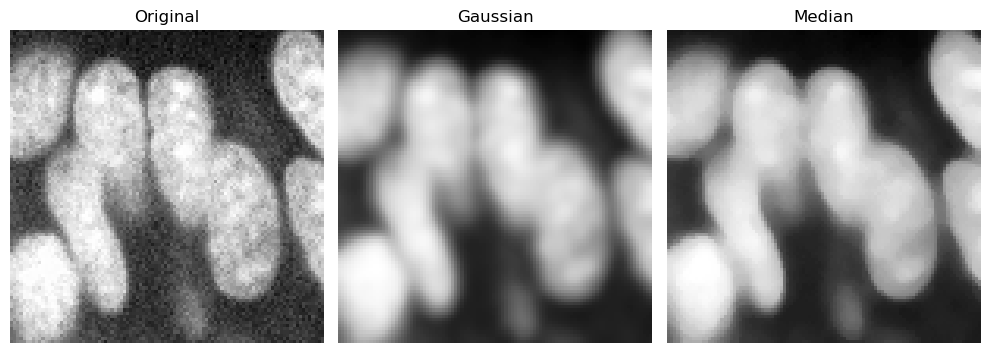

In [3]:
cropped_zfish = zfish_image[630:730, 500:600]

zfish_gaussian = gaussian(cropped_zfish, sigma=2, preserve_range=True)
zfish_median = median(cropped_zfish, footprint=disk(4))

fig, axs = plt.subplots(1, 3, figsize=(10,10))

imshow(cropped_zfish, plot=axs[0])
axs[0].set_title("Original")
imshow(zfish_gaussian, plot=axs[1])
axs[1].set_title("Gaussian")
imshow(zfish_median, plot=axs[2])
axs[2].set_title("Median")
for ax in axs:
    ax.axis('off')
plt.tight_layout()

## Background Reduction

There are also background reduction methods. If there is a more or less homogeneous intensity spread over the whole image, potentially increasing in a direction, it is recommended to remove this background before segmenting the image.

To subtract the background, we need to determine it first. There are several algorithms that are useful for removing inhomogeneous background.

### Rolling ball algorithm

Well known to FIJI users, the [rolling-ball algorithm](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rolling_ball.html) is still widely used to remove background. The radius parameter determines the largest object that should not be considered background.

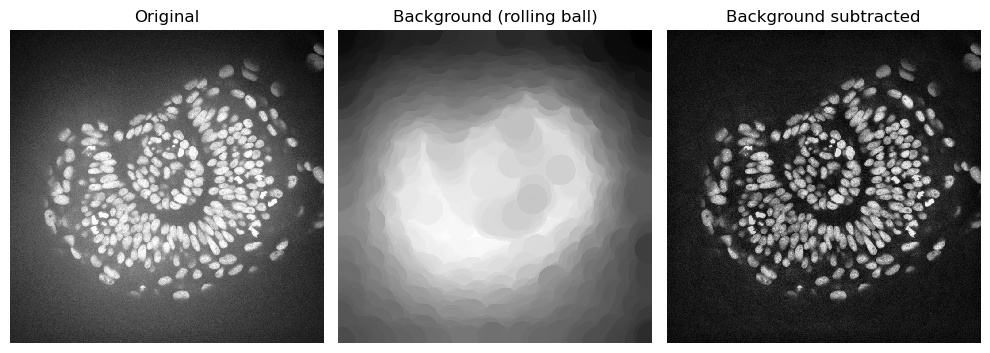

In [4]:
# Apply rolling ball
background_rolling = rolling_ball(zfish_image, radius=50)

# Subtract background
zfish_rolling = zfish_image - background_rolling

# Display results
fig, axs = plt.subplots(1, 3, figsize=(10,10))

imshow(zfish_image, plot=axs[0])
axs[0].set_title("Original")
imshow(background_rolling, plot=axs[1])
axs[1].set_title("Background (rolling ball)")
imshow(zfish_rolling, plot=axs[2])
axs[2].set_title("Background subtracted")
for ax in axs:
    ax.axis('off')
plt.tight_layout()

### Tophat filter
The [white_tophat](https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#white-tophat) filter gives very similar results to the rolling ball algorithm, but is algorithmically much simpler. The footprint parameter determines the largest object that should not be considered background. The output already contains the image without the background.

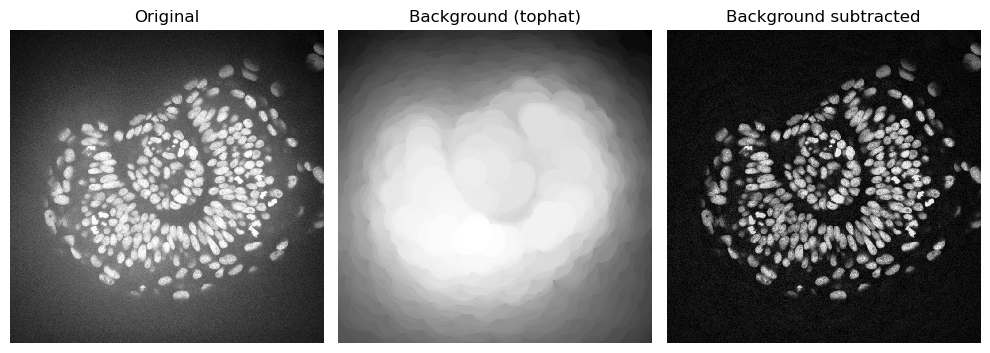

In [5]:
# Apply white top-hat filter
zfish_tophat = white_tophat(zfish_image, footprint=disk(50))

# Estimated background
background_tophat = zfish_image - zfish_tophat

fig, axs = plt.subplots(1, 3, figsize=(10,10))

imshow(zfish_image, plot=axs[0])
axs[0].set_title("Original")
imshow(background_tophat, plot=axs[1])
axs[1].set_title("Background (tophat)")
imshow(zfish_tophat, plot=axs[2])
axs[2].set_title("Background subtracted")
for ax in axs:
    ax.axis('off')
plt.tight_layout()

For a faster version of the top-hat filter, consider using the GPU-accelerated version from [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype/tree/master#py-clesperanto) (`cle.top_hat_box` or `cle.top_hat_sphere`) instead. Check a benchmark notebook [here](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/benchmarks/top_hat.ipynb).

cl.OCLArray([[1316., 1476., 1463., ..., 1214.,  999., 1244.],
       [1860., 1284., 1732., ..., 1575.,  391., 1487.],
       [ 770.,  339., 2171., ..., 1130.,  960., 1633.],
       ...,
       [1676., 1882., 2810., ..., 1132., 2381., 1469.],
       [2069., 3031., 1803., ..., 1683., 1058., 1304.],
       [1631., 1999., 2714., ...,  956., 2771., 1275.]], dtype=float32)
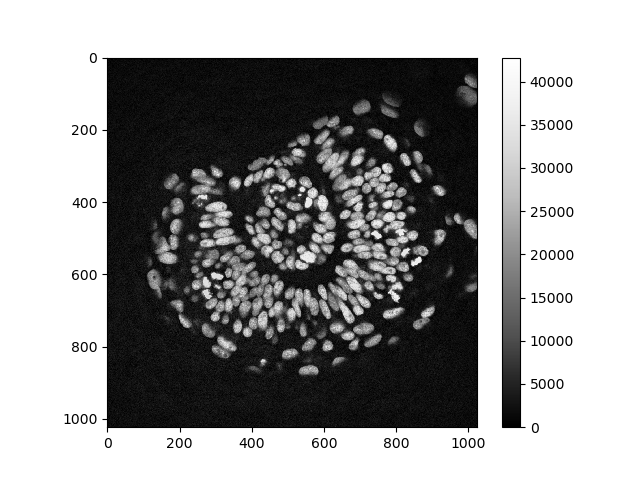
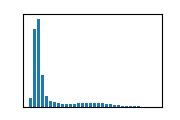

In [6]:
import pyclesperanto_prototype as cle
cle.top_hat_sphere(zfish_image, radius_x=50, radius_y=50)

### Difference of Gaussians
In many cases, background subtraction is combined with denoising. The [Difference of Gaussians (DoG)](https://scikit-image.org/docs/stable/auto_examples/filters/plot_dog.html) performs both operations in one function. 

It uses a strong gaussian blur (large sigma) as an estimation of the background and a weak blur (small sigma) to reduce noise. Then, it subtracts the reduced noise one from the background estimation.

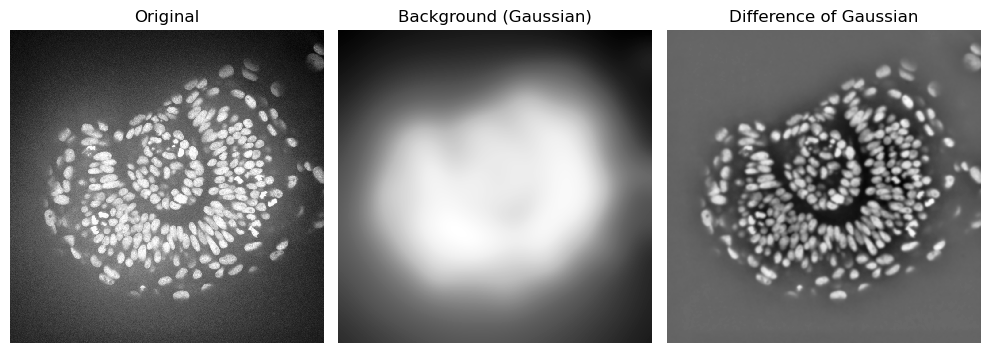

In [7]:
# Background estimated from strong gaussian blur
background_gaussian = gaussian(zfish_image, sigma=50, preserve_range=True)

# Apply difference of gaussian
zfish_difference_of_gaussians = difference_of_gaussians(zfish_image, 3, 50)

fig, axs = plt.subplots(1, 3, figsize=(10,10))

imshow(zfish_image, plot=axs[0])
axs[0].set_title("Original")
imshow(background_gaussian, plot=axs[1])
axs[1].set_title("Background (Gaussian)")
imshow(zfish_difference_of_gaussians, plot=axs[2])
axs[2].set_title("Difference of Gaussian")
for ax in axs:
    ax.axis('off')
plt.tight_layout()

### Difference from Median

For highlighting small structures, it may be useful to subtract a median filter from the original iamge instead of a large gaussian blur.

Check the example below.

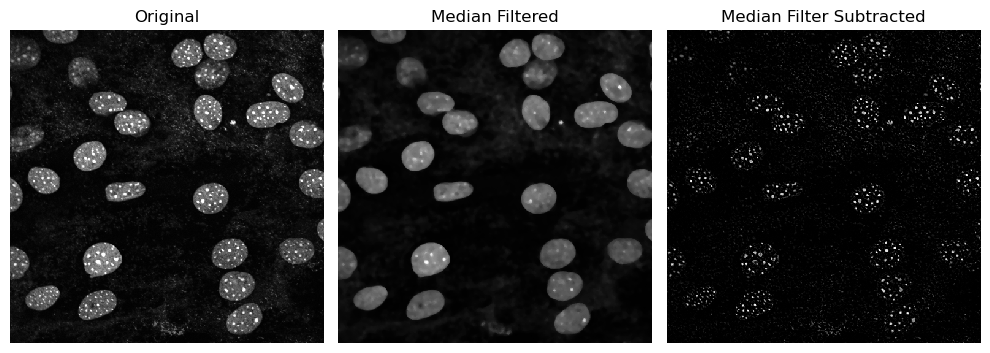

In [8]:
C2C12_nuclei = imread('../../data/C2C12_nuclei.tif').astype(float)

# Median filter (with a footprint element of 4 pixels)
median_filtered = median(C2C12_nuclei, footprint=disk(4)).astype(float)

# Subtract median filtered image from original
median_filter_subtracted = C2C12_nuclei - median_filtered

fig, axs = plt.subplots(1, 3, figsize=(10,10))

imshow(C2C12_nuclei, plot=axs[0])
axs[0].set_title("Original")
imshow(median_filtered, plot=axs[1])
axs[1].set_title("Median Filtered")
imshow(median_filter_subtracted, plot=axs[2], 
    min_display_intensity=0, 
    max_display_intensity=median_filter_subtracted.max()
    )
axs[2].set_title("Median Filter Subtracted")
for ax in axs:
    ax.axis('off')
plt.tight_layout()

## Filters: Edge Detection

Edge detection highlights parts of the image where there are **sharp** signal intensity _changes_.

A common filter for edge detection is the `sobel` filter. There are other like `laplace`, `scharr` and `farid`. Check [sckimage.filters](https://scikit-image.org/docs/dev/api/skimage.filters.html#) for more filter options.

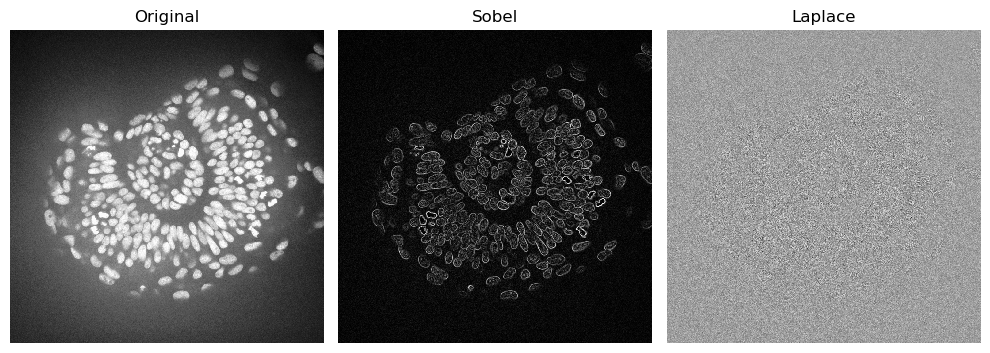

In [9]:
from skimage.filters import sobel, laplace

zfish_sobel = sobel(zfish_image)

zfish_laplace = laplace(zfish_image, ksize=3)

fig, axs = plt.subplots(1, 3, figsize=(10,10))

imshow(zfish_image, plot=axs[0])
axs[0].set_title("Original")
imshow(zfish_sobel, plot=axs[1])
axs[1].set_title("Sobel")
imshow(zfish_laplace, plot=axs[2])
axs[2].set_title("Laplace")
for ax in axs:
    ax.axis('off')
plt.tight_layout()

The laplacian works best if the image is first denoised. Let's apply the laplacian to an image where we reduced the noise

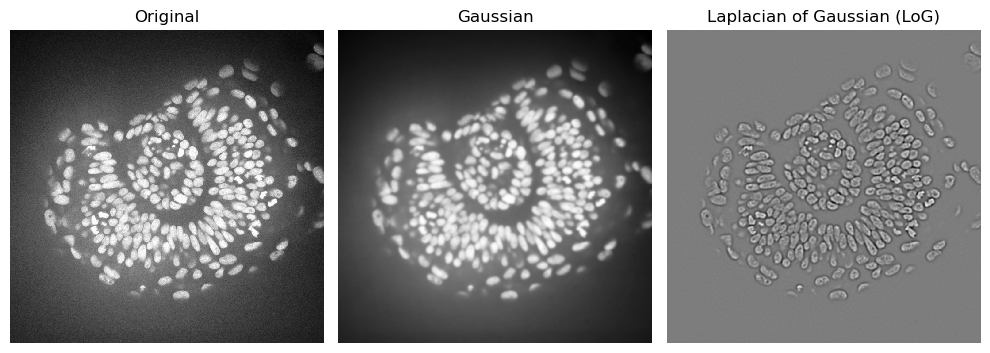

In [10]:
zfish_gaussian = gaussian(zfish_image, sigma=3)
zfish_laplacian_of_gaussian = laplace(zfish_gaussian)

fig, axs = plt.subplots(1, 3, figsize=(10,10))

imshow(zfish_image, plot=axs[0])
axs[0].set_title("Original")
imshow(zfish_gaussian, plot=axs[1])
axs[1].set_title("Gaussian")
imshow(zfish_laplacian_of_gaussian, plot=axs[2])
axs[2].set_title("Laplacian of Gaussian (LoG)")
for ax in axs:
    ax.axis('off')
plt.tight_layout()

# Exercises

Open the `human_mitosis_noisy.tif` image and choose the best combination of filters to remove noise and background. Display the results.

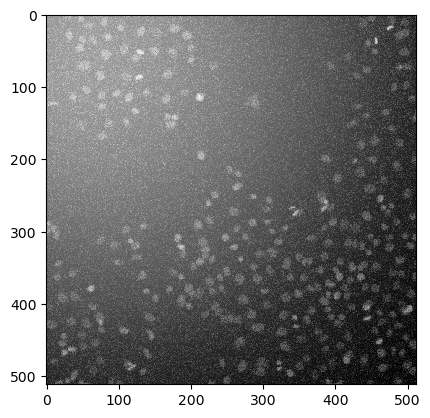

In [11]:
image = imread('../../data/human_mitosis_noisy.tif')
imshow(image)

In [12]:
# Run filters here
# image_filt = 